In [18]:
import glob
import logging
import os
import random
import json
from tqdm import tqdm
import re

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange
from sklearn.metrics import classification_report, confusion_matrix

from transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
from transformers import AdamW, get_linear_schedule_with_warmup

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Ti'

## Load the dataset

In [ ]:
import pandas as pd

directory = r".../youtube/dataset/"
train = pd.read_csv(directory + "train.csv", index_col=0)
test = pd.read_csv(directory + "test.csv", index_col=0)

print(np.sum(test["CLASS"]))
print(np.sum(train["CLASS"]))

train.head()

191
814


,AUTHOR,CONTENT,CLASS
1069,Tan Jia Min,Check out this video on YouTube:..🌈🌈🌈﻿,1
1345,Durgesh Rathod,fav.﻿,0
259,The Bibliophile Flautist,"Hey everyone, I am a new channel and will post...",1
1076,2010shevy,Check out this video on YouTube:﻿,1
60,Eanna Cusack,Im just to check how much views it has﻿,0


In [4]:
print('Training set size:', train.shape[0])
print('Test set size:', test.shape[0])

Training set size: 1600
Test set size: 356


### Examples of comments

In [5]:
def is_spam(x):
    if x == 1:
        return 'Spam'
    else:
        return 'Not spam'

In [6]:
for i,comment in enumerate(train['CONTENT'].iloc[:20]):
    print(f"{is_spam(train['CLASS'].iloc[i])}   :{comment}")

Spam   :Check out this video on YouTube:..🌈🌈🌈﻿
Not spam   :fav.﻿
Spam   :Hey everyone, I am a new channel and will post videos of book reviews and  music on the flute. Please subscribe if you would enjoy that. Thanks!﻿
Spam   :Check out this video on YouTube:﻿
Not spam   :Im just to check how much views it has﻿
Spam   :plz subscribe to my channel i need subs and if you do i will sub back i  need help﻿
Not spam   :Good times ...﻿
Not spam   :great song you go katy!﻿
Spam   :Check out this video on YouTube:﻿
Spam   :Hey guys and girls check out Comedy Recipe for hilarious you tube videos, pranks, and crank calls!
Not spam   :And after the video ends, a 13 ft. boa constrictor squeezes her to death.﻿
Not spam   :Stop,is a very TOP 1﻿
Spam   :Aye homies check out our remix to 50 Cent Your Life Is On The Line we just started our youtube channel and we are all ways working hard, give us some feed back on our latest song on what you guys think if you like show support.﻿
Not spam   :I love this

In [7]:
for i,comment in enumerate(train['AUTHOR'].iloc[:25]):
    print(f"{is_spam(train['CLASS'].iloc[i])}   :{comment}")

Spam   :Tan Jia Min
Not spam   :Durgesh Rathod
Spam   :The Bibliophile Flautist
Spam   :2010shevy
Not spam   :Eanna Cusack
Spam   :themind blasters
Not spam   :Matheus Ribeiro
Not spam   :bea boots
Spam   :Darleen Tran
Spam   :Comedy Recipe
Not spam   :Justin Chery
Not spam   :lol Ippocastano
Spam   :CypherBrothers
Not spam   :Sonny Carter
Not spam   :MrTuizentfloot
Not spam   :no honesty
Not spam   :Jimmy Hopkins
Spam   :TWIN MELODY
Not spam   :Kirill Nazarethian
Not spam   :Martwy Karas
Spam   :Derek Moya
Spam   :Whami inc.
Spam   :Emilie
Not spam   :Peter Wilkes
Not spam   :Intan  Nadia


# Preprocessing

In [8]:
model_name = "BERT"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if model_name == "BERT":
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

MAX_LEN = 256
batch_size = 8

# Extract authors, content, and labels
train_authors = train['AUTHOR'].astype(str).tolist()
train_contents = train['CONTENT'].astype(str).tolist()
train_labels = train['CLASS'].astype(int).tolist()

test_authors = test['AUTHOR'].astype(str).tolist()
test_contents = test['CONTENT'].astype(str).tolist()
test_labels = test['CLASS'].astype(int).tolist()

# Now tokenize by providing both sequences to the tokenizer
# Sequence A: AUTHOR
# Sequence B: CONTENT
train_encodings = tokenizer(
    train_authors,
    train_contents,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

test_encodings = tokenizer(
    test_authors,
    test_contents,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Extract input_ids, attention_masks, and token_type_ids
train_input_ids = train_encodings['input_ids']
train_attention_masks = train_encodings['attention_mask']
train_token_type_ids = train_encodings['token_type_ids']

test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']
test_token_type_ids = test_encodings['token_type_ids']

# Convert labels to tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Convert labels to tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create TensorDatasets
train_data = TensorDataset(train_input_ids, train_attention_masks, train_token_type_ids, train_labels)
test_data = TensorDataset(test_input_ids, test_attention_masks, test_token_type_ids, test_labels)


# Create DataLoaders
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [9]:
model_name = "BERT"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if model_name == "BERT":
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

MAX_LEN = 256
batch_size = 8

# Extract only CONTENT and labels, ignoring author this time
train_contents2 = train['CONTENT'].astype(str).tolist()
train_labels2 = train['CLASS'].astype(int).tolist()

test_contents2 = test['CONTENT'].astype(str).tolist()
test_labels2 = test['CLASS'].astype(int).tolist()

# Tokenize only CONTENT (single sequence)
train_encodings2 = tokenizer(
    train_contents2,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

test_encodings2 = tokenizer(
    test_contents2,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Extract input_ids and attention_masks (no token_type_ids needed for single sequence)
train_input_ids2 = train_encodings2['input_ids']
train_attention_masks2 = train_encodings2['attention_mask']

test_input_ids2 = test_encodings2['input_ids']
test_attention_masks2 = test_encodings2['attention_mask']

# Convert labels to tensors
train_labels2 = torch.tensor(train_labels2)
test_labels2 = torch.tensor(test_labels2)

# Create TensorDatasets (no token_type_ids since we're using single sequence)
train_data2 = TensorDataset(train_input_ids2, train_attention_masks2, train_labels2)
test_data2 = TensorDataset(test_input_ids2, test_attention_masks2, test_labels2)

# Create DataLoaders
train_sampler2 = RandomSampler(train_data2)
train_dataloader2 = DataLoader(train_data2, sampler=train_sampler2, batch_size=batch_size)

test_sampler2 = SequentialSampler(test_data2)
test_dataloader2 = DataLoader(test_data2, sampler=test_sampler2, batch_size=batch_size)

In [10]:
if model_name == "BERT":
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=2,                # Binary classification
        output_attentions=False,     # Whether the model returns attentions weights.
        output_hidden_states=False   # Whether the model returns all hidden-states.
    )

model.to(device)

if model_name == "BERT":
    model2 = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=2,                # Binary classification
        output_attentions=False,     # Whether the model returns attentions weights.
        output_hidden_states=False   # Whether the model returns all hidden-states.
    )

model2.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Fine-Tuning

In [12]:
epochs = 3

# Optimizer and Scheduler for model1
param_optimizer1 = list(model.named_parameters())
no_decay1 = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters1 = [
    {
        'params': [p for n, p in param_optimizer1 if not any(nd in n for nd in no_decay1)],
        'weight_decay': 0.01
    },
    {
        'params': [p for n, p in param_optimizer1 if any(nd in n for nd in no_decay1)],
        'weight_decay': 0.0
    }
]
optimizer1 = AdamW(optimizer_grouped_parameters1, lr=2e-5, eps=1e-8)

# Total number of training steps for model 1
total_steps1 = len(train_dataloader) * epochs

# Scheduler for model1
scheduler1 = get_linear_schedule_with_warmup(
    optimizer1,
    num_warmup_steps=0,
    num_training_steps=total_steps1
)

# Optimizer and Scheduler for model2
param_optimizer2 = list(model2.named_parameters())
no_decay2 = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters2 = [
    {
        'params': [p for n, p in param_optimizer2 if not any(nd in n for nd in no_decay2)],
        'weight_decay': 0.01
    },
    {
        'params': [p for n, p in param_optimizer2 if any(nd in n for nd in no_decay2)],
        'weight_decay': 0.0
    }
]
optimizer2 = AdamW(optimizer_grouped_parameters2, lr=2e-5, eps=1e-8)

# Total number of training steps for model2
total_steps2 = len(train_dataloader2) * epochs

# Scheduler for model2
scheduler2 = get_linear_schedule_with_warmup(
    optimizer2,
    num_warmup_steps=0,
    num_training_steps=total_steps2
)

# Compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
# Initialize lists to store loss and accuracy
train_loss_set1 = []
train_loss_set2 = []
validation_accuracy_set1 = []
validation_accuracy_set2 = []

# Define number of epochs

for epoch in range(epochs):
    print(f'Epoch {epoch + 1} / {epochs}')
    
    # Train model1 (AUTHOR + CONTENT)
    model.train()
    tr_loss1 = 0
    nb_tr_steps1 = 0
    
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training model1 (AUTHOR+CONTENT)")):
        # Unpack the batch and move to device
        b_input_ids, b_input_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)
        
        # Clear gradients
        optimizer1.zero_grad()
        
        # Forward pass
        outputs1 = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask,
            token_type_ids=b_token_type_ids,
            labels=b_labels
        )
        
        loss1 = outputs1.loss
        logits1 = outputs1.logits
        
        # Accumulate loss
        train_loss_set1.append(loss1.item())
        tr_loss1 += loss1.item()
        nb_tr_steps1 += 1
        
        # Backward pass
        loss1.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters and scheduler
        optimizer1.step()
        scheduler1.step()
    
    avg_train_loss1 = tr_loss1 / nb_tr_steps1
    print(f"\n  Average training loss for model1: {avg_train_loss1:.4f}")
    
    # Train model2 (CONTENT only)
    model2.train()
    tr_loss2 = 0
    nb_tr_steps2 = 0
    
    for step, batch in enumerate(tqdm(train_dataloader2, desc="Training model2 (CONTENT only)")):
        # Unpack the batch and move to device
        b_input_ids2, b_input_mask2, b_labels2 = tuple(t.to(device) for t in batch)
        
        # Clear gradients
        optimizer2.zero_grad()
        
        # Forward pass
        outputs2 = model2(
            input_ids=b_input_ids2,
            attention_mask=b_input_mask2,
            labels=b_labels2
        )
        
        loss2 = outputs2.loss
        logits2 = outputs2.logits
        
        # Accumulate loss
        train_loss_set2.append(loss2.item())
        tr_loss2 += loss2.item()
        nb_tr_steps2 += 1
        
        # Backward pass
        loss2.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        
        # Update parameters and scheduler
        optimizer2.step()
        scheduler2.step()
    
    avg_train_loss2 = tr_loss2 / nb_tr_steps2
    print(f"\n  Average training loss for model2: {avg_train_loss2:.4f}")
    
    # Validation for model1
    model.eval()
    eval_accuracy1 = 0
    nb_eval_steps1 = 0
    predictions1, true_labels1 = [], []
    
    for batch in tqdm(test_dataloader, desc="Validating model1"):
        # Unpack the batch and move to device
        b_input_ids, b_input_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)
        
        with torch.no_grad():
            outputs1 = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
                token_type_ids=b_token_type_ids
            )
        
        logits1 = outputs1.logits
        
        # Move logits and labels to CPU
        logits1 = logits1.detach().cpu().numpy()
        label_ids1 = b_labels.cpu().numpy()
        
        # Calculate accuracy
        tmp_eval_accuracy1 = flat_accuracy(logits1, label_ids1)
        eval_accuracy1 += tmp_eval_accuracy1
        nb_eval_steps1 += 1
        
        # Collect predictions and true labels for detailed report
        predictions1.append(logits1)
        true_labels1.append(label_ids1)
    
    avg_val_accuracy1 = eval_accuracy1 / nb_eval_steps1
    validation_accuracy_set1.append(avg_val_accuracy1)
    print(f"  Validation Accuracy for model1: {avg_val_accuracy1:.4f}")
    
    # Validation for model2
    model2.eval()
    eval_accuracy2 = 0
    nb_eval_steps2 = 0
    predictions2, true_labels2 = [], []
    
    for batch in tqdm(test_dataloader2, desc="Validating model2"):
        # Unpack the batch and move to device
        b_input_ids2, b_input_mask2, b_labels2 = tuple(t.to(device) for t in batch)
        
        with torch.no_grad():
            outputs2 = model2(
                input_ids=b_input_ids2,
                attention_mask=b_input_mask2
            )
        
        logits2 = outputs2.logits
        
        # Move logits and labels to CPU
        logits2 = logits2.detach().cpu().numpy()
        label_ids2 = b_labels2.cpu().numpy()
        
        # Calculate accuracy
        tmp_eval_accuracy2 = flat_accuracy(logits2, label_ids2)
        eval_accuracy2 += tmp_eval_accuracy2
        nb_eval_steps2 += 1
        
        # Collect predictions and true labels for detailed report
        predictions2.append(logits2)
        true_labels2.append(label_ids2)
    
    avg_val_accuracy2 = eval_accuracy2 / nb_eval_steps2
    validation_accuracy_set2.append(avg_val_accuracy2)
    print(f"  Validation Accuracy for model2: {avg_val_accuracy2:.4f}")
    
    # Classification Report and Confusion Matrix for model1
    all_predictions1 = np.concatenate(predictions1, axis=0)
    all_true_labels1 = np.concatenate(true_labels1, axis=0)
    preds_flat1 = np.argmax(all_predictions1, axis=1).flatten()

    print("Confusion Matrix for model1:")
    print(confusion_matrix(all_true_labels1, preds_flat1))
    
    # Classification Report and Confusion Matrix for model2
    all_predictions2 = np.concatenate(predictions2, axis=0)
    all_true_labels2 = np.concatenate(true_labels2, axis=0)
    preds_flat2 = np.argmax(all_predictions2, axis=1).flatten()

    print("Confusion Matrix for model2:")
    print(confusion_matrix(all_true_labels2, preds_flat2))

Epoch 1 / 3


Training model1 (AUTHOR+CONTENT): 100%|██████████| 200/200 [00:39<00:00,  5.12it/s]



  Average training loss for model1: 0.2352


Training model2 (CONTENT only): 100%|██████████| 200/200 [00:58<00:00,  3.41it/s]



  Average training loss for model2: 0.2271


Validating model1: 100%|██████████| 45/45 [00:06<00:00,  7.14it/s]


  Validation Accuracy for model1: 0.9583


Validating model2: 100%|██████████| 45/45 [00:06<00:00,  7.23it/s]


  Validation Accuracy for model2: 0.9556
Confusion Matrix for model1:
[[162   3]
 [ 12 179]]
Confusion Matrix for model2:
[[163   2]
 [ 14 177]]
Epoch 2 / 3


Training model1 (AUTHOR+CONTENT): 100%|██████████| 200/200 [00:59<00:00,  3.39it/s]



  Average training loss for model1: 0.0842


Training model2 (CONTENT only): 100%|██████████| 200/200 [00:59<00:00,  3.36it/s]



  Average training loss for model2: 0.0838


Validating model1: 100%|██████████| 45/45 [00:08<00:00,  5.19it/s]


  Validation Accuracy for model1: 0.9611


Validating model2: 100%|██████████| 45/45 [00:09<00:00,  4.95it/s]


  Validation Accuracy for model2: 0.9639
Confusion Matrix for model1:
[[162   3]
 [ 11 180]]
Confusion Matrix for model2:
[[161   4]
 [  9 182]]
Epoch 3 / 3


Training model1 (AUTHOR+CONTENT): 100%|██████████| 200/200 [01:04<00:00,  3.08it/s]



  Average training loss for model1: 0.0199


Training model2 (CONTENT only): 100%|██████████| 200/200 [01:05<00:00,  3.07it/s]



  Average training loss for model2: 0.0301


Validating model1: 100%|██████████| 45/45 [00:10<00:00,  4.30it/s]


  Validation Accuracy for model1: 0.9611


Validating model2: 100%|██████████| 45/45 [00:07<00:00,  5.66it/s]

  Validation Accuracy for model2: 0.9667
Confusion Matrix for model1:
[[161   4]
 [ 10 181]]
Confusion Matrix for model2:
[[161   4]
 [  8 183]]


In [25]:
# torch.save(model, r"...\youtube\models\BERT_model.pt")

# Testing accuracy of this fine-tuned model on a different dataset: Random spam (multiple sources: email, comments...)

In [ ]:
# Binary format function
def to_binary(label):
    if label != 'spam':
        return 0
    else:
        return 1

def clean_text(text):
    text = str(text)
    
    # 1. Normalize whitespace and newlines
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    return text

directory = r".../spam/dataset/"
train_spam = pd.read_parquet(directory + "train.parquet")
test_spam = pd.read_parquet(directory + "test.parquet")

all = pd.concat([train_spam,test_spam], axis=0)
all['label'] = all['label'].apply(to_binary)
all['text'] = all['text'].apply(clean_text)
all.rename(columns={'text':'CONTENT','label':'CLASS'}, inplace=True)

In [20]:
# Extract only CONTENT and labels, ignoring author
all_contents = all['CONTENT'].astype(str).tolist()
all_labels = all['CLASS'].astype(int).tolist()

# Tokenize only CONTENT (single sequence)
all_encodings = tokenizer(
    all_contents,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Extract input_ids and attention_masks (no token_type_ids needed for single sequence)
all_input_ids = all_encodings['input_ids']
all_attention_masks = all_encodings['attention_mask']

# Convert labels to tensors
all_labels = torch.tensor(all_labels)

# Create TensorDatasets (no token_type_ids since we're using single sequence)
all_data = TensorDataset(all_input_ids, all_attention_masks, all_labels)

# Create DataLoaders
all_sampler = RandomSampler(all_data)
all_dataloader = DataLoader(all_data, sampler=all_sampler, batch_size=batch_size)

In [21]:
# Validation
model.eval()
eval_accuracy = 0
nb_eval_steps = 0

for batch in all_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
    
    with torch.no_grad():
        outputs = model2(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.cpu().numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("Validation Accuracy on random spam: {}".format(eval_accuracy/nb_eval_steps))

Validation Accuracy on random spam: 0.5730924431401321


#### Learning curve

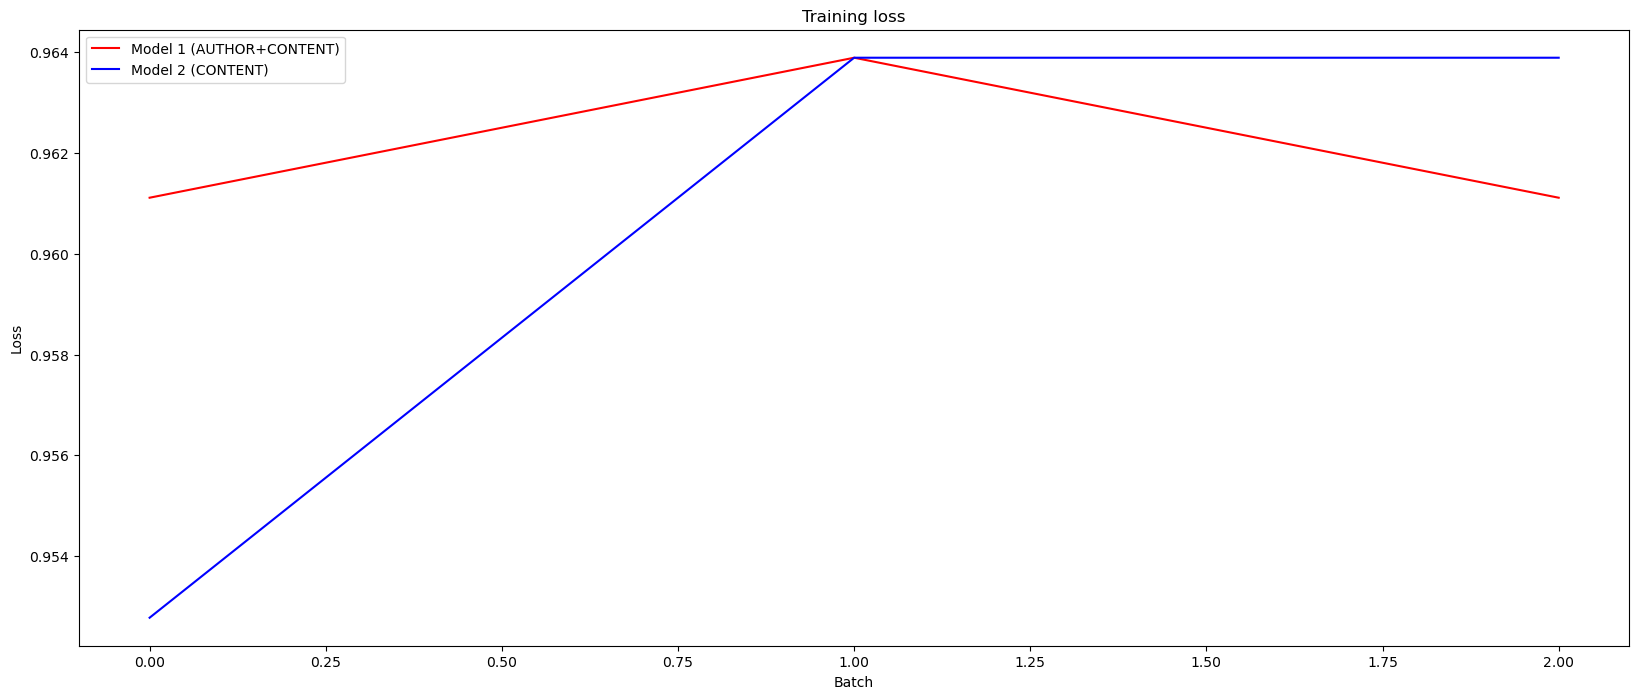

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(validation_accuracy_set1, color='r', label='Model 1 (AUTHOR+CONTENT)')
plt.plot(validation_accuracy_set2, color='b', label='Model 2 (CONTENT)')
plt.legend()
plt.show()